In [4]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib

import os
import numpy as np
import ncvis
import pickle

from vis_utils.loaders import load_dataset
from vis_utils.utils import  save_dict, load_dict, KL_divergence, kNN_graph,   joint_support, KL_divergence_sparse ,pythagorean_defect, sort_sims_by_proximity, acc_kNN
from vis_utils.plot import hists_from_graph_embd, plot_scatter
import sys
sys.path.append("..")
from scripts.utils import get_path


env: CUDA_VISIBLE_DEVICES=1


In [5]:
root_path = get_path("data")
fig_path = get_path("figures")

In [18]:
# parameters for all methods
dataset = "mnist"
k=15
seeds = [0, 1, 2]
seed = 0
a=1.0
b=1.0
rescale = 1.0


In [7]:
# set up matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = "Times New Roman"
cmap = matplotlib.cm.get_cmap("tab10")

In [8]:
# get data
x, y, sknn_graph, pca2 = load_dataset(root_path, dataset)

# Original NCVis code

In [9]:
n_epochs = 750
alpha = 1.0
alpha_Q = 0.001
n_noise = 5
noise_in_ratio = n_noise
fix_Q = False
learn_Q = True
affinities = np.stack([sknn_graph.row, sknn_graph.col], axis=1)


In [10]:
ncvis_data_list = []
for s in seeds:
    file_name = os.path.join(root_path,
                                 dataset,
                                 f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{s}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")

    if rescale:
        pca_ncvis = pca2 / np.std(pca2[:, 0]) * rescale
    else:
        pca_ncvis = pca2
    try:
        ncvis_data = load_dict(file_name)
    except FileNotFoundError:
        ncvisualizer = ncvis.NCVis(n_epochs=n_epochs,
                                   random_seed=s,
                                   fix_Q=fix_Q,
                                   noise_in_ratio=noise_in_ratio,
                                   learn_Q=learn_Q,
                                   n_noise=n_noise,
                                   alpha=alpha,
                                   alpha_Q=alpha_Q,
                                   a=a,
                                   b=b)

        embd = ncvisualizer.fit_transform(x,
                                          affinities=affinities,
                                          init=pca_ncvis,
                                          log_embds=True,
                                          log_nce=False,
                                          log_nce_norm=False,
                                          log_nce_no_noise=False)
        ncvis_data = ncvisualizer.aux_data

        save_dict(ncvis_data, file_name)
    ncvis_data_list.append(ncvis_data)
    print(f"Done with seed {s}")


Done with seed 0
Done with seed 1
Done with seed 2


<AxesSubplot:>

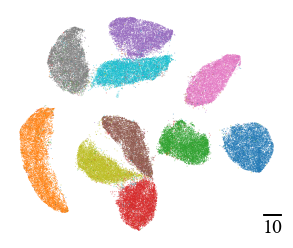

In [11]:
epoch=-1
plt.figure(figsize=(5,5))

plot_scatter(plt.gca(), ncvis_data_list[0]["embds"][epoch], y)

In [12]:
final_Z = np.array([np.exp(ncvis_data["qs"][-1]) for ncvis_data in ncvis_data_list] ) * len(x) * (len(x) -1) # scale by noise distribution
final_Z_mean = final_Z.mean()
final_Z_std = final_Z.std()

In [13]:
print("{:.2E}".format(final_Z_mean ))
print("{:.2E}".format(final_Z_std ))

3.43E+07
9.38E+04


In [14]:
final_norm = np.array([ncvis_data["normalization"][-1] for ncvis_data in ncvis_data_list] )
final_norm_mean = final_norm.mean()
final_norm_std  =final_norm.std()

In [15]:
print("{:.2E}".format(final_norm_mean ))
print("{:.2E}".format(final_norm_std ))

1.52E+07
1.86E+04


# CNE framework

In [16]:
clamp_low = 1e-10
lr_min_factor = 0.0
momentum = 0.0
anneal_lr = True
loss_mode = "nce"
batch_size = 1024
parametric = False
optimizer = "sgd"

## vary n_noise

In [19]:
nbs_noise = [ 5, 50, 500]
n_epochs = 750

embedders = []
init = "pca"

for n_noise in nbs_noise:
    file_name = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_{init}_rescale_{rescale}_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{seed}.pkl")
    with open(file_name, "rb") as file:
        embedder = pickle.load(file)

    embedders.append(embedder)
    print(f"done with n_noise={n_noise}")

done with n_noise=5
done with n_noise=50
done with n_noise=500


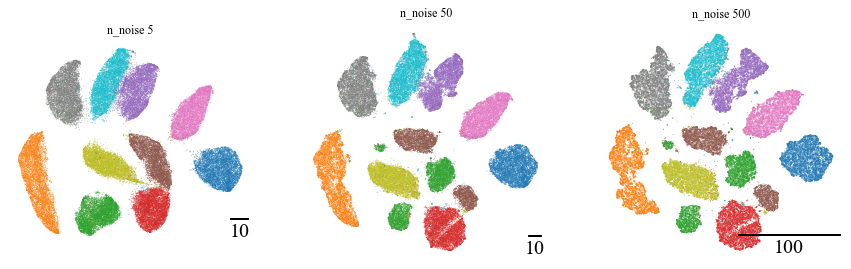

In [20]:
epoch = -1
fig, ax = plt.subplots(1, 3, figsize=(15,15))
for i in range(len(embedders)):
    embd = embedders[i].callback.embds[epoch]
    cax = ax[i]
    plot_scatter(cax, embd, y, f"n_noise {nbs_noise[i]}")

In [8]:
epoch = -1
for i in range(len(embedders)):
    plt.figure(figsize=(5,5))
    embd = embedders[i].callback.embds[epoch]
    plot_scatter(plt.gca(), embd, y)
    plt.savefig(os.path.join(fig_path,
                         f"nce_no_EE_m_{nbs_noise[i]}.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')
    plt.close()

## early exaggeration

In [22]:
# early exaggeration phase
n_noise = 5
n_epochs = 250


file_name = os.path.join(root_path,
                         dataset,
                         f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_pca_rescale_{rescale}_bs_{batch_size}"
                         f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{seed}.pkl")
with open(file_name, "rb") as file:
    embedder_init = pickle.load(file)


<AxesSubplot:>

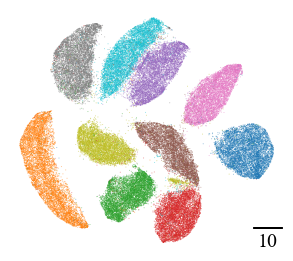

In [23]:
plt.figure(figsize=(5,5))
plot_scatter(plt.gca(), embedder_init.callback.embds[-1], y)

In [24]:
nbs_noise = [ 5, 50, 500]

n_epochs = 500
init = "EE"
embedders = []

for n_noise in nbs_noise:
    file_name = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_{init}_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{seed}.pkl")
    with open(file_name, "rb") as file:
        embedder = pickle.load(file)

    embedders.append(embedder)
    print(f"done with n_noise={n_noise}")

done with n_noise=5
done with n_noise=50
done with n_noise=500


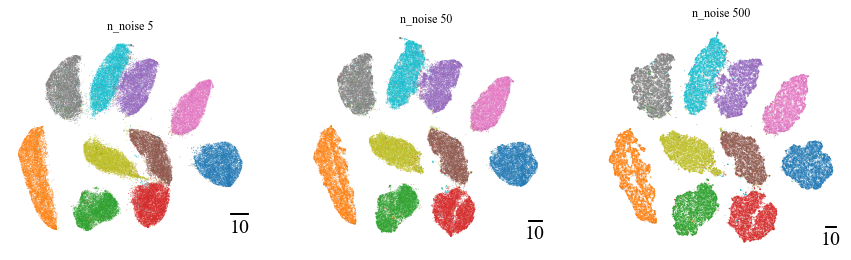

In [25]:
epoch = -1
fig, ax = plt.subplots(1, 3, figsize=(15,15))
for i in range(len(embedders)):
    embd = embedders[i].callback.embds[epoch]
    cax = ax[i]
    plot_scatter(cax, embd, y, f"n_noise {nbs_noise[i]}")


In [15]:
epoch = -1
for i in range(len(embedders)):
    plt.figure(figsize=(5,5))
    embd = embedders[i].callback.embds[epoch]
    plot_scatter(plt.gca(), embd, y)
    plt.savefig(os.path.join(fig_path,
                         f"nce_m_{nbs_noise[i]}.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')
    plt.close()

## random init

In [27]:
nbs_noise = [5, 50, 500]
n_epochs = 750

init = "random"
embedders = []

for n_noise in nbs_noise:
    file_name = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{n_noise}_n_epochs_{n_epochs}_init_{init}_rescale_{rescale}_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{seed}.pkl")
    with open(file_name, "rb") as file:
        embedder = pickle.load(file)

    embedders.append(embedder)
    print(f"done with n_noise={n_noise}")

done with n_noise=5
done with n_noise=50
done with n_noise=500


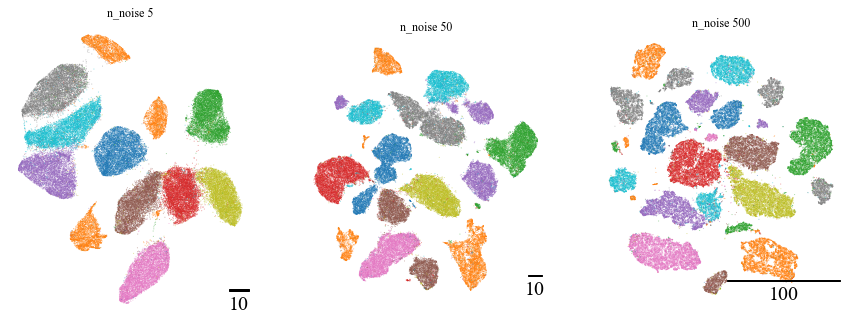

In [28]:
epoch = -1
fig, ax = plt.subplots(1, 3, figsize=(15,15))
for i in range(len(embedders)):
    embd = embedders[i].callback.embds[epoch]
    cax = ax[i]
    plot_scatter(cax, embd, y, f"n_noise {nbs_noise[i]}")


In [18]:
epoch = -1
for i in range(len(embedders)):
    plt.figure(figsize=(5,5))
    embd = embedders[i].callback.embds[epoch]
    plot_scatter(plt.gca(), embd, y)
    plt.savefig(os.path.join(fig_path,
                         f"nce_random_m_{nbs_noise[i]}.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200,
            transparent=False,
            facecolor='white')
    plt.close()